# Gaussian Processes

This notebook is a collection of notes taken from Nando de Freitas's lecture series:

- [Introduction to Gaussian processes](https://www.youtube.com/watch?v=4vGiHC35j9s)
- [Gaussian processes](https://www.youtube.com/watch?v=MfHKW5z-OOA)

supplemented by various resources, including:

- [Gortler - A Visual Exploration of Gaussian Processes](https://distill.pub/2019/visual-exploration-gaussian-processes/)
- [Bailey - Gaussian Processes for Dummies](https://katbailey.github.io/post/gaussian-processes-for-dummies/)
- [Krasser - Gaussian processes](https://krasserm.github.io/2018/03/19/gaussian-processes/)

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

## Introduction

### Gaussian Basics

- Consider a 2D Gaussian RV:

$$
f\left(\begin{bmatrix} x_1 \\ x_2 \end{bmatrix}\right) = \mathcal{N}\left(\begin{bmatrix} \mu_1 \\ \mu_2 \end{bmatrix}, \begin{bmatrix} \Sigma_{x_1 x_1} & \Sigma_{x_1 x_2} \\ \Sigma_{x_2 x_1} & \Sigma_{x_2 x_2}\end{bmatrix}\right)
$$

- Here, $\mu$ represents the centre of the Gaussian, and $\Sigma$ represents how "tilted" the Gaussian is (since covariance indicates whether we'd expect $x_1$ to increase if $x_2$ increases).
- The covariance matrix must be symmetric and positive definite for the Gaussian to be well-defined (I think the covariance matrix is defined to satisfy both).
- Visualization:

In [17]:
# From https://scipython.com/blog/visualizing-the-bivariate-gaussian-distribution/
def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos."""

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

def plot_bivariate_gaussian(mu=np.array([0., 0.]),
                            Sigma=np.array([[ 0.5 , 0.1], [0.1,  0.5]])):
    # Our 2-dimensional distribution will be over variables X and Y
    N = 40
    X = np.linspace(-3, 3, N)
    Y = np.linspace(-3, 3, N)
    X, Y = np.meshgrid(X, Y)

    # Pack X and Y into a single 3-dimensional array
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y

    # The distribution on the variables X, Y packed into pos.
    Z = multivariate_gaussian(pos, mu, Sigma)

    # plot using subplots
    fig = plt.figure(figsize=(6, 6))

    ax = fig.add_subplot(111)
    ax.contourf(X, Y, Z, cmap=cm.viridis)

    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$x_2$')
    
    plt.show()

<IPython.core.display.Javascript object>


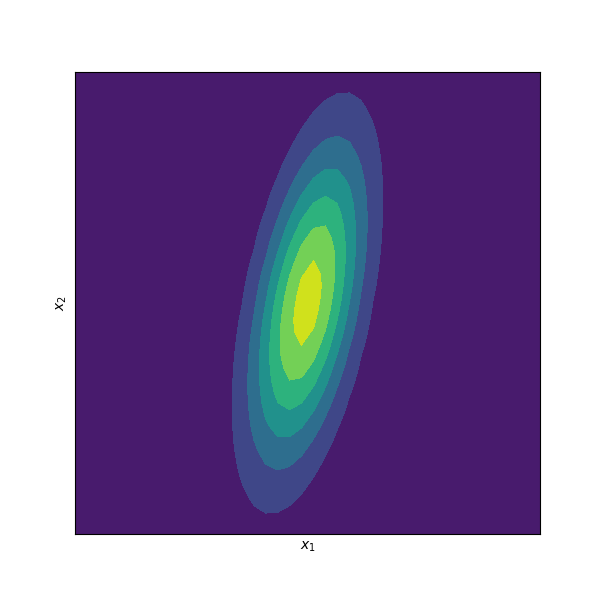

In [21]:
plot_bivariate_gaussian(Sigma=np.array([[ 0.25 , 0.35], [0.35,  2]]))

- $f$ can be considered the PDF of two RVs:

$$
P(X_1, X_2) = f(x_1, x_2)
$$

- A slice along one dimension of $f$ is the conditional PDF:

$$
f(x_1=x', x_2) =P(X_2|X_1=x')
$$

- Is there a straightforward way to determine the $\mu$ and $\Sigma$ of the conditional PDF?  Yes!  Using the Schur's complement ([Matrix Cookbook](https://www.math.uwaterloo.ca/~hwolkowi//matrixcookbook.pdf) 8.1.3, [Bishop](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf) 2.3.1), it's:

\begin{eqnarray}
\mu_{2|1} &=& \mu_2 + \Sigma_{x_2x_1}\Sigma_{x_1x_1}^{-1}(x'-\mu_1)\\
\Sigma_{2|1} &=& \Sigma_{22} - \Sigma_{12}\Sigma_{22}^{-1}\Sigma_{21}
\end{eqnarray}

- How do we go from a multivariate standard normal to a multivariate Gaussian?  (It's trivial to do for 1D case.)
  - To do this we need to take the square root of a Gaussian - Cholesky decomposition gives us square root of $\Sigma$, $L$, such that:
  $$ \Sigma = LL^T $$
  - Then
  $$ \vec{x} \sim \vec{\mu} + L\mathcal{N}(\vec{0}, I) $$

### Learning a Function

- Consider a function $f(x)$; we try to learn it from known data $x$.

In [2]:
x = np.array([1., 2., 3.])
f = np.array([0.5, 1., 7.])

<IPython.core.display.Javascript object>


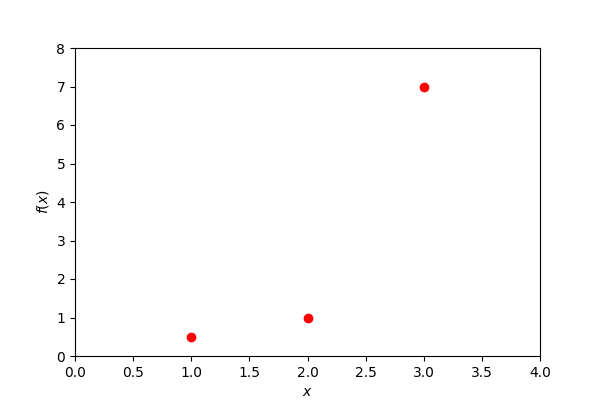

In [3]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(x, f, 'ro')
ax.set_xlim(0., 4.)
ax.set_ylim(0., 8.)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$f(x)$");

In [26]:
def squared_exponential_kernel(x, lambd=1.):
    return np.exp(-lambd * (x[:, np.newaxis] - x[np.newaxis, :])**2)

squared_exponential_kernel(x)

array([[1.        , 0.36787944, 0.01831564],
       [0.36787944, 1.        , 0.36787944],
       [0.01831564, 0.36787944, 1.        ]])

<IPython.core.display.Javascript object>


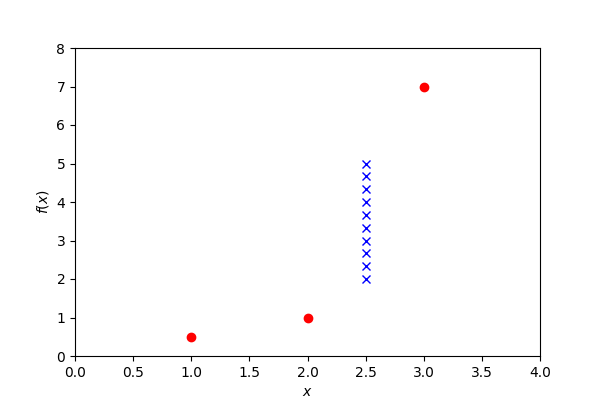

In [28]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(x, f, 'ro')
ax.plot(2.5 * np.ones(10), np.linspace(2, 5, 10), 'bx')
ax.set_xlim(0., 4.)
ax.set_ylim(0., 8.)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$f(x)$");